# Exercise 5: Gradient Descent & Performance Evaluation

In [1]:
# Load packages we need
import sys
import os

import numpy as np
import sklearn

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 18})

# Let's check our software versions
print('### Python version: ' + sys.version)
print('### Numpy version: ' + np.__version__)
print('### Scikit-learn version: ' + sklearn.__version__)
print('------------')


# load our packages / code
sys.path.insert(1, '../common/')
import utils
import plots

### Python version: 3.8.10 (default, Nov 26 2021, 20:14:08) 
[GCC 9.3.0]
### Numpy version: 1.22.0
### Scikit-learn version: 1.0.2
------------


In [2]:
# global parameters to control behavior of the pre-processing, ML, analysis, etc.

seed = 42 # deterministic seed

np.random.seed(seed) 

train_prop = 0.75
test_prop = 1.0 - train_prop

### Loading data

In [3]:
from sklearn.datasets import load_iris

# For this exercise, we'll load a dataset directly from scikit-learn
iris = load_iris()
# Ref: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html

all_x = iris['data']
all_y = iris['target']

classes = iris['target_names']
features = iris['feature_names'] 

print(classes)
print(features)
# let's check the shape to know what we are getting
print(all_x.shape, all_y.shape)

['setosa' 'versicolor' 'virginica']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
(150, 4) (150,)


In [4]:
# We'll use only two classes ('versicolor', 'virginica')
class1_idx = 1
class2_idx = 2

sel_classes = [classes[class1_idx], classes[class2_idx]]


versicolor_label = 1
virginica_label = 2

sel_idx_1 = np.where(all_y == versicolor_label)[0]
sel_idx_2 = np.where(all_y == virginica_label)[0]

sel_idx = np.r_[sel_idx_1, sel_idx_2]
# Note: we could use np.hstack((sel_idx_1, sel_idx_2)) instead

sel_x = all_x[sel_idx,:]
sel_y = all_y[sel_idx]

# and grab only the last two features (i.e., 'petal length', 'petal_width')

feature1_idx = 2
feature2_idx = 3

proc_x = sel_x[:, [feature1_idx, feature2_idx]]
proc_y = sel_y - 1 # subtract 1 so that class 0 is versicolor and class 1 is virginica

# recheck the shapes
print(proc_x.shape, proc_y.shape)

(100, 2) (100,)


In [5]:
# train - test split
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(proc_x, proc_y, train_size=train_prop, test_size=test_prop, random_state=seed)

# first check the shapes
print(train_x.shape, train_y.shape)

(75, 2) (75,)


### Let's look at the data

In [6]:
# what does the (training) data look like?
train_x[0:3,:]

array([[4.4, 1.4],
       [4.4, 1.2],
       [5. , 1.9]])

In [7]:
# what does the data look like?
train_y[0:10]

array([0, 0, 1, 0, 1, 0, 0, 1, 0, 1])

### Let's train a LogisticRegression model

In [8]:
from sklearn.linear_model import LogisticRegression
## ref: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

model = LogisticRegression(penalty='none', random_state=seed).fit(train_x, train_y)

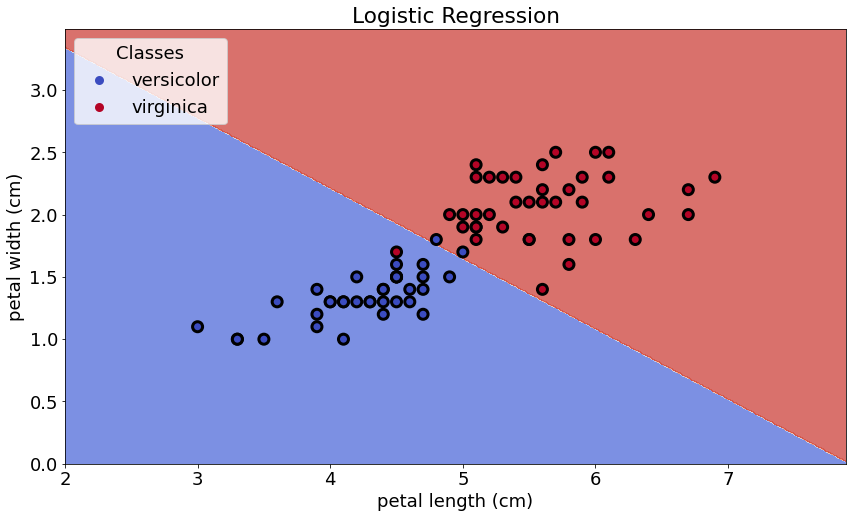

In [9]:
# plot to show classifier's decision boundary and training examples
title = 'Logistic Regression'

fig, ax = plt.subplots(figsize=(14,8))

X0, X1 = train_x[:, 0], train_x[:, 1]
xx, yy = plots.make_meshgrid(X0, X1, h=0.01)

plots.contours(ax, model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.75)

scatter = ax.scatter(X0, X1, c=train_y, cmap=plt.cm.coolwarm, s=100, linewidth=3, edgecolors='k')

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xlabel(features[feature1_idx])
ax.set_ylabel(features[feature2_idx])

handles, labels = scatter.legend_elements()
ax.legend(handles, sel_classes, loc="upper left", title="Classes")

ax.set_title(title)
plt.show()

## Now, let's evaluate our model

In [10]:
from sklearn import metrics

# make predictions on test set
pred_y = model.predict(test_x)

# are those prediction correct?
acc_score = metrics.accuracy_score(test_y, pred_y)
print('Test accuracy: {:.2f}%'.format(acc_score*100))

# make predictions on *training* set
pred_y = model.predict(train_x)

acc_score = metrics.accuracy_score(train_y, pred_y)
print('Training accuracy: {:.2f}%'.format(acc_score*100))

Test accuracy: 88.00%
Training accuracy: 96.00%


## Can we train a logistic regression model using batch gradient descent?

In [11]:
# Taken from assignment 4
def batch_gradient_descent(X, y, gradient_fn, lr_schedule_fn, num_iter=1000, stop_fn = None, verbose=False):
    (n, m) = X.shape
    theta = np.random.uniform(low=-1.0, high=1.0, size=(X.shape[1],1)) # initialize uniformly at random in [-1, 1]
    
    for i in range(0, num_iter):
        eta = lr_schedule_fn(i) # learning rate
        
        gradient = gradient_fn(X, y, theta) # calculate gradient vector
        assert gradient.shape == theta.shape
        
        prev_theta = theta 
        
        # update theta (actual gradient descent step)
        theta = theta - eta * gradient
        
        # compute diff 
        diff = theta - prev_theta
        l2ndiff = np.linalg.norm(diff)
        
        if verbose and i % (num_iter/20) == 0:
            print('Iter {}, learning rate: {:.6f}, diff in theta (L2-norm): {:.6f}.'.format(i, eta, l2ndiff))
            
        if stop_fn is not None and stop_fn(diff):
            if verbose:
                print('Stop condition reached (iter {}).'.format(i))
            break
    
    return theta.reshape(-1,), i

### Gradient of the logistic loss (aka log loss)?

In [12]:
def sigmoid(X, theta):
    dotprod = np.dot(X, theta)
    return 1.0 / (1 + np.exp(- dotprod))

def gradient_logloss(X, y, theta):
    (n, m) = X.shape
    
    y = y.reshape(-1,1)
    assert y.shape == (n,1) and theta.shape == (m,1)
    
    ### The gradient of log loss is: 1/n (sigmoid(θ X) - y) X   (note: θ = theta)   
    res = sigmoid(X, theta) - y
    return 1.0/n * np.dot(X.T, res)

In [13]:
# do the batch gradient descent

# add a constant feature of 1 to each row to account for the bias term
X_with_b = np.c_[np.ones((train_x.shape[0],1)), train_x]

learning_rate = 0.5
lr_sched_fn = lambda t: learning_rate / (1 + np.log(1+t))

# actually run the gradient descent and store the result in theta
theta, _ = batch_gradient_descent(X_with_b, train_y, gradient_logloss, lr_sched_fn, num_iter=500000, verbose=True)

Iter 0, learning rate: 0.500000, diff in theta (L2-norm): 1.073602.
Iter 25000, learning rate: 0.044937, diff in theta (L2-norm): 0.000265.
Iter 50000, learning rate: 0.042302, diff in theta (L2-norm): 0.000147.
Iter 75000, learning rate: 0.040899, diff in theta (L2-norm): 0.000103.
Iter 100000, learning rate: 0.039959, diff in theta (L2-norm): 0.000078.
Iter 125000, learning rate: 0.039259, diff in theta (L2-norm): 0.000063.
Iter 150000, learning rate: 0.038704, diff in theta (L2-norm): 0.000053.
Iter 175000, learning rate: 0.038248, diff in theta (L2-norm): 0.000045.
Iter 200000, learning rate: 0.037861, diff in theta (L2-norm): 0.000039.
Iter 225000, learning rate: 0.037527, diff in theta (L2-norm): 0.000034.
Iter 250000, learning rate: 0.037232, diff in theta (L2-norm): 0.000030.
Iter 275000, learning rate: 0.036970, diff in theta (L2-norm): 0.000027.
Iter 300000, learning rate: 0.036734, diff in theta (L2-norm): 0.000024.
Iter 325000, learning rate: 0.036519, diff in theta (L2-nor

### How good is the model?

In [14]:
# given model parameters 'theta' and a feature matrix 'x', this will return predictions
def predict_theta_logistic(theta, x):
    b = theta[0]
    w = theta[1:]
    
    assert w.shape[0] == x.shape[1]
    
    return 1.0 / (1 + np.exp(- (np.dot(w, x.T) + b) ))

In [15]:
# Print the weights and bias for both models
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

print('Logistic Regression model -- w: {}, b: {:.3f}'.format(model.coef_[0], model.intercept_[0]))
print('Logistic Regression Batch Gradient Descent model -- w: {}, b: {:.3f}'.format(theta[1:], theta[0]))

Logistic Regression model -- w: [ 5.714  10.121], b: -45.233
Logistic Regression Batch Gradient Descent model -- w: [ 4.963  9.122], b: -39.803


In [16]:
pred_y_proba = predict_theta_logistic(theta, test_x)
pred_y = (pred_y_proba > 0.5).astype(int)

test_acc_score = metrics.accuracy_score(test_y, pred_y)
print('Test accuracy: {:.2f}%'.format(test_acc_score*100))

pred_y_proba = predict_theta_logistic(theta, train_x)
pred_y = (pred_y_proba > 0.5).astype(int)

train_acc_score = metrics.accuracy_score(train_y, pred_y)
print('Train accuracy: {:.2f}%'.format(train_acc_score*100))

Test accuracy: 88.00%
Train accuracy: 96.00%


## Let's wrap our model in a custom estimator

In [17]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

# Check out: https://scikit-learn.org/stable/developers/develop.html
class CustomGDLogisticClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, max_iter=500000):
        self.threshold = 0.5
        self.max_iter = max_iter
        
        return

    def fit(self, X, y):

        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        
        assert np.array_equal(self.classes_, [0,1])
        
        X_with_b = np.c_[np.ones((X.shape[0],1)), X]

        grad_fn = gradient_logloss

        lr_sched_fn = lambda i: 0.5

        # actually run the gradient descent and store the result in theta
        theta, _ = batch_gradient_descent(X_with_b, train_y, grad_fn, lr_sched_fn, num_iter=self.max_iter, verbose=False)
        
        self.theta = theta
        self.b = theta[0]
        self.w = theta[1:]
        
        # Return the classifier
        return self

    def predict_proba(self, X):
        check_is_fitted(self) # Check is fit had been called
        X = check_array(X) # Input validation

        return predict_theta_logistic(self.theta, X)
    
    def predict(self, X):
        check_is_fitted(self) # Check is fit had been called
        X = check_array(X) # Input validation

        proba = self.predict_proba(X)
        return (proba > self.threshold).astype(int)
    
    def set_threshold(thresh):
        self.threshold = thresh

### Let's train our custom classifier

In [18]:
custom_logistic = CustomGDLogisticClassifier().fit(train_x, train_y)

### Is the decision boundary similar?

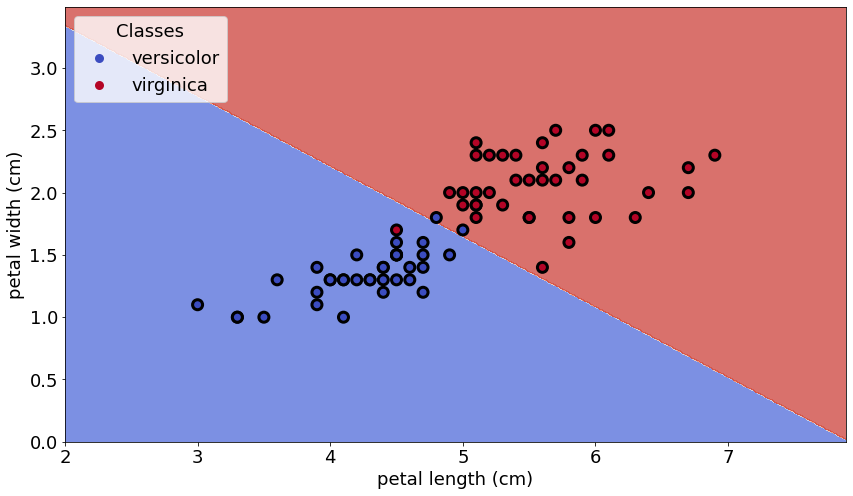

In [19]:
def plot_decision_boundary(fig, ax, m, lw=3, psz=100):
    X0, X1 = train_x[:, 0], train_x[:, 1]
    xx, yy = plots.make_meshgrid(X0, X1, h=0.01)

    plots.contours(ax, m, xx, yy, cmap=plt.cm.coolwarm, alpha=0.75)

    scatter = ax.scatter(X0, X1, c=train_y, cmap=plt.cm.coolwarm, s=psz, linewidth=lw, edgecolors='k')

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(features[feature1_idx])
    ax.set_ylabel(features[feature2_idx])

    
fig, ax = plt.subplots(figsize=(14,8))

plot_decision_boundary(fig, ax, custom_logistic)

handles, labels = scatter.legend_elements()
ax.legend(handles, sel_classes, loc="upper left", title="Classes")

plt.show()

## Let's look at the model throughout gradient descent

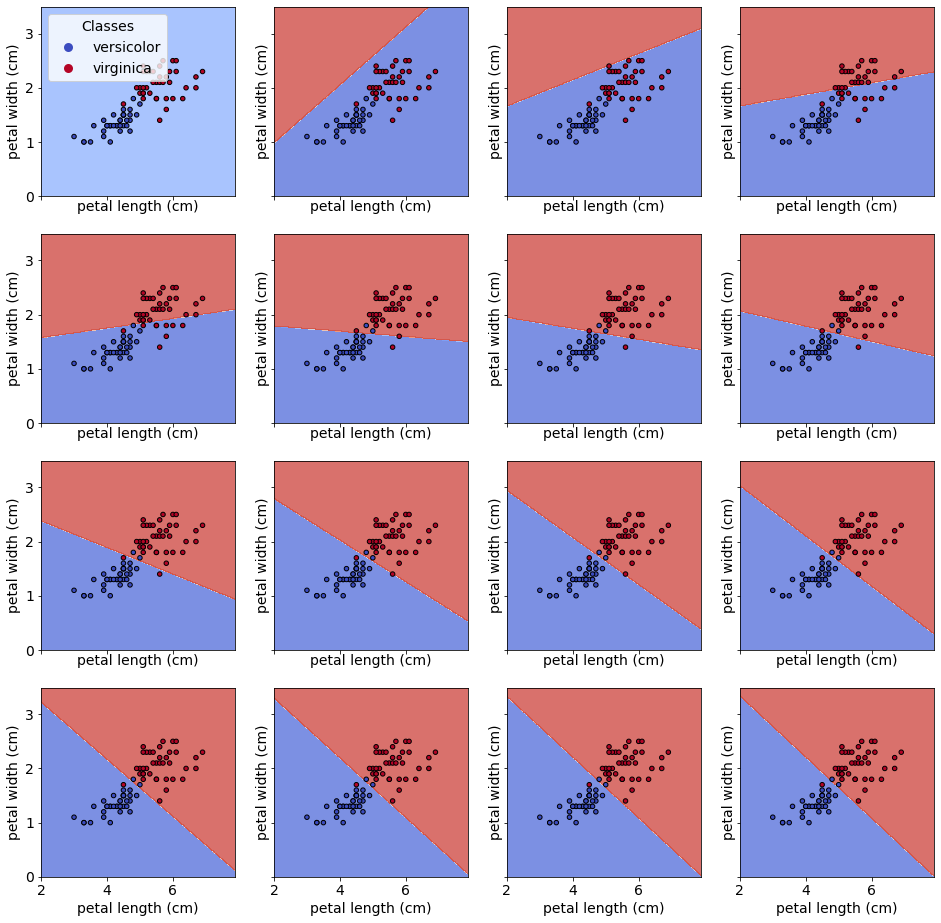

In [20]:
num = 16
nr = nc = int(np.sqrt(num))

plt.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(nrows=nr, ncols=nc, figsize=(16, 16), sharex='all', sharey='all')

iters = [ 5, 10, 100, 200, 250,
          500, 750, 1000, 2000, 5000, 7500, 10000,
         25000, 50000, 100000, 500000]

for i in range(0, nr):
    for j in range(0, nr):
        ax = axs[i][j]

        max_iter = int(iters[i*nr+j])
        custom = CustomGDLogisticClassifier(max_iter).fit(train_x, train_y) # train for max_iter
        
        plot_decision_boundary(fig, ax, custom, lw=1, psz=20)
                
        if i == 0 and j ==0:
            handles, labels = scatter.legend_elements()
            ax.legend(handles, sel_classes, loc="upper left", title="Classes")

plt.show()

### Let's look at classification metrics

In [21]:
from sklearn.metrics import confusion_matrix, classification_report

pred_y = custom_logistic.predict(test_x)

In [22]:
cm = confusion_matrix(test_y, pred_y)
tn, fp, fn, tp = cm.ravel()

In [23]:
print('Confusion matrix: \n', cm)

accuracy = np.trace(cm) / np.sum(np.sum(cm))
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print('Accuracy: {:.2f}%, precision: {:.2f}%, recall: {:.2f}%'.format(100*accuracy, 100*precision, 100*recall))

Confusion matrix: 
 [[13  1]
 [ 2  9]]
Accuracy: 88.00%, precision: 90.00%, recall: 81.82%


In [24]:
f1score = 2 * (precision * recall) / (precision + recall)
print('F1-score: {:.3f}'.format(f1score))

F1-score: 0.857


In [25]:
print(classification_report(test_y, pred_y, digits=3, target_names=sel_classes))

              precision    recall  f1-score   support

  versicolor      0.867     0.929     0.897        14
   virginica      0.900     0.818     0.857        11

    accuracy                          0.880        25
   macro avg      0.883     0.873     0.877        25
weighted avg      0.881     0.880     0.879        25



### Plot a ROC curve

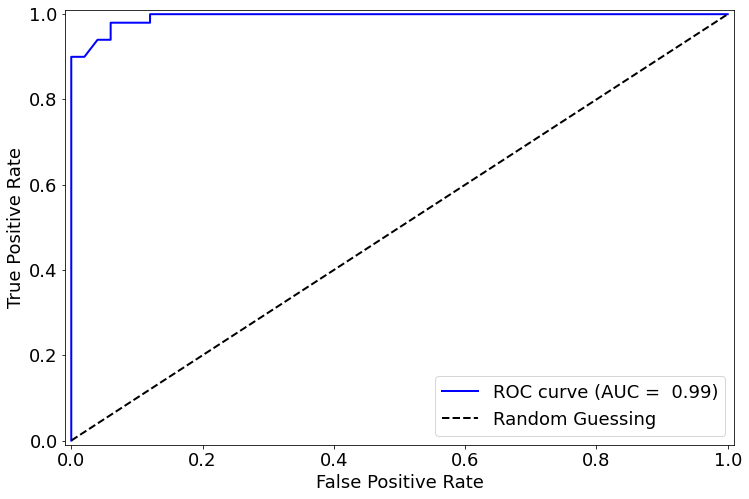

In [26]:
from sklearn.metrics import roc_curve, auc

# get the probabilities
pred_proba = custom_logistic.predict_proba(proc_x)

fpr, tpr, thresh = roc_curve(proc_y, pred_proba)
aucv = auc(fpr, tpr)


plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(12,8))

plt.plot(fpr, tpr, color='b',lw=2, label='ROC curve (AUC = {: .2f})'.format(aucv))
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--', label='Random Guessing')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()